# Impact Causal

In [21]:
# Carregando as principais bibliotecas com o 'import'

# Removendo warnings chatos
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from causalimpact import CausalImpact, summary
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.stats import spearmanr
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sn

In [2]:
# lendo o dataframe
data = pd.read_csv('dados.csv')

In [3]:
data

,data,receita,transacoes_blog,transacoes_site,usuarios_blog,usuarios_site
0,2019-01-01,349184,0,4693,0,46739
1,2019-01-02,867328,0,8501,0,83129
2,2019-01-03,758590,0,9375,0,86067
3,2019-01-04,688873,0,8405,0,69363
4,2019-01-05,441760,0,6136,0,56183
...,...,...,...,...,...,...
634,2020-09-26,2509687,1580,15320,9292,96178
635,2020-09-27,2182679,1838,14135,10052,103494
636,2020-09-28,3496475,2684,21724,11224,127524
637,2020-09-29,4519732,3037,28017,11570,150116


### O  nosso campo de data está identificado como object vamos usar o comando Datetime (específico para lidar com datas e horários) para transformar o tipo da variável Podemos usar o comando pd.to_datetime() para fazer essa conversão. 

In [4]:
# Convertendo o campo `Date` para datetime
data['data'] = pd.to_datetime(data['data'])

# Checando o resutado
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639 entries, 0 to 638
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   data             639 non-null    datetime64[ns]
 1   receita          639 non-null    int64         
 2   transacoes_blog  639 non-null    int64         
 3   transacoes_site  639 non-null    int64         
 4   usuarios_blog    639 non-null    int64         
 5   usuarios_site    639 non-null    int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 30.1 KB


In [5]:
data.data = pd.to_datetime(data.data)

In [6]:
# colocando a data como index

data.set_index('data', inplace=True)

In [7]:
print('Quantidade de linhas e colunas:', data.shape)
print('Quantidade de dados nulos:', data.isna().sum().sum())

Quantidade de linhas e colunas: (639, 5)
Quantidade de dados nulos: 0


In [8]:
print('Menor data: {}'.format(data.index.min())) # Mínimo
print('Maior data: {}'.format(data.index.max())) # Máximo

Menor data: 2019-01-01 00:00:00
Maior data: 2020-09-30 00:00:00


In [9]:
data.describe()

,receita,transacoes_blog,transacoes_site,usuarios_blog,usuarios_site
count,6.390000e+02,639.000000,639.000000,639.000000,639.000000
mean,1.623891e+06,528.350548,19039.140845,1439.848200,101610.485133
std,1.160581e+06,1201.781347,13677.729723,3369.872063,37240.234152
min,3.208500e+04,0.000000,3557.000000,0.000000,26298.000000
25%,8.073420e+05,0.000000,11013.000000,0.000000,77727.000000
50%,1.263161e+06,0.000000,16069.000000,0.000000,96104.000000
75%,2.232770e+06,0.000000,22606.500000,0.000000,117586.500000
max,1.226684e+07,5586.000000,188955.000000,13059.000000,369989.000000


# Análisando a correlação entre as variáveis. 
Abaixo temos a matriz de correlação entre as variáveis em que permitirá interpretar as relação entre as mesmas. Nessa matriz podemos ver uma escala de cores de tonalidades de laranja, vermelho e roxo, e uma escala numérica que vai de 1 a -1. O interessante dessa representação gráfica é que além da barra lateral que demonstra a escala numérica do coeficiente e das cores, há também em cada quadrante o valor e a cor referente da relação. 
As variáveis que estão dentro da escala de 1 a 0,7, possuem uma forte correlação; já as variáveis que estão entre 0,7 a 0,5 possuem correlação moderada e as variáveis que possuem escala de 0,5 a 0,25 possuem baixa; e por fim as variáveis com coeficiente próximo a 0 não possuem correlação.

In [10]:
correlation = data.corr()

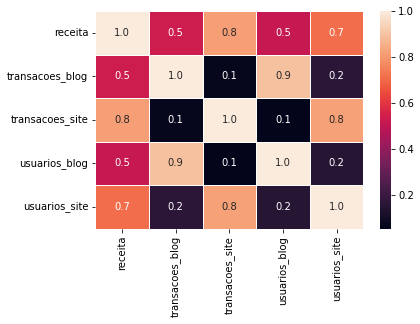

In [11]:
plot = sn.heatmap(correlation, annot = True, fmt=".1f", linewidths=.6)

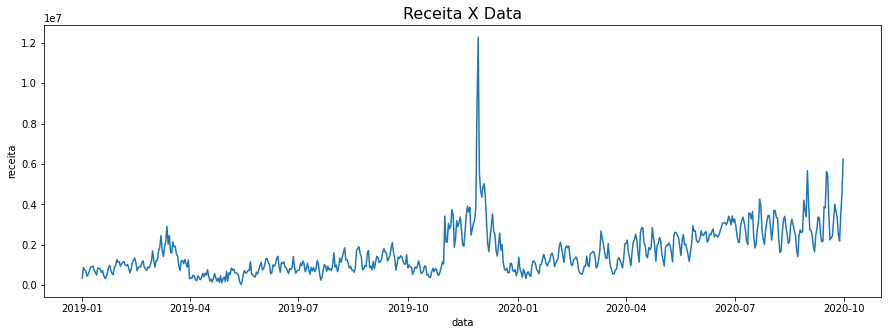

In [12]:
plt.figure(figsize=(15,5))
plt.plot(data.index,data.receita)
plt.ylabel('receita')
plt.xlabel('data')
plt.title('Receita X Data',size=16)
#plt.axhline(y=0, color='r', linestyle='-')
plt.show()

Ocorreu um outlier no periodo de dezembro, o que indica sazonalidade, como no caso natal e black friday.

# Análise de estacionariedade 

* Foi feita uma análise de estacionariedade ou seja, caso a série não seja estacionária a previsão para o futuro não será eficiente, pois as variações de valores ao redor da média se afastam significativamente, porém como calculado abaixo, durante o periodo de treino, os dados são estacionários, mostrando que consigo fazer uma análise efetiva.



In [13]:
from statsmodels.tsa.stattools import adfuller

significancia = 0.05

# Instanciando o teste (o p-valor é sempre o SEGUNDO número da tupla)
teste_fuller_estac = adfuller(data.receita[:512])

if(teste_fuller_estac[1] <= significancia): 
    print("O p-valor do teste foi de {:.2f}.".format(teste_fuller_estac[1]), 'A série é estacionária.')
else:
    print("O p-valor do teste foi de {:.2f}.".format(teste_fuller_estac[1]), 'A série não é estacionária.')


#output = pd.Series(teste_fuller_estac[0:4], index = ['Teste', 'p-valor','Lags','Número de observações usadas'])

#for key, value in teste_fuller_estac[4].items():
  #output['Valor crítico(%s)' %key] = value
#print(output)

O p-valor do teste foi de 0.04. A série é estacionária.


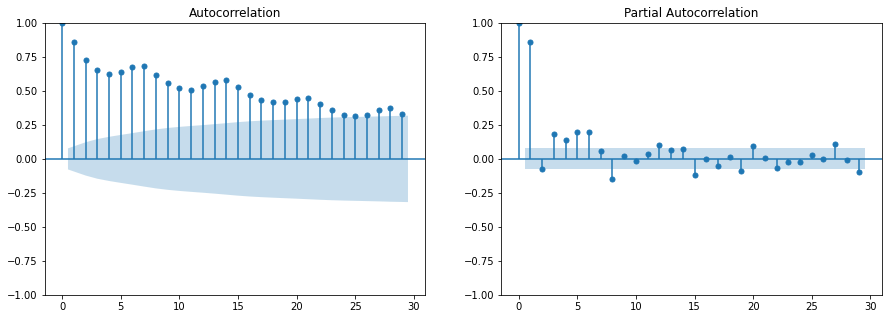

In [14]:
# Construindo os gráficos
# ACF
fig, ax = plt.subplots(1,2,figsize=(15,5)) # Cria um grid de dois gráficos, na horizontal
plot_acf(data.receita,ax=ax[0], zero=True) # A correlação(0) sempre será 1


#PACF
plot_pacf(data.receita,ax=ax[1],zero=True) # A correlação(0) sempre será 1

plt.suptitle("",size=16)

plt.show()

# Fazendo o Impact Causal

In [15]:
data['transacoes_total'] = data['transacoes_site'] + data['transacoes_blog'] 

In [16]:
data2 = data[['receita', 'transacoes_total']]

In [17]:
ci = CausalImpact(data2, ["2019-01-01", "2020-05-31"], ["2020-06-01", "2020-09-30"], model_args={'fit_method': 'hmc'})

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`


2022-07-20 17:53:02.589588: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-20 17:53:02.589638: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-20 17:53:02.589658: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ALK-PE08T8BN): /proc/driver/nvidia/version does not exist
2022-07-20 17:53:02.589904: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


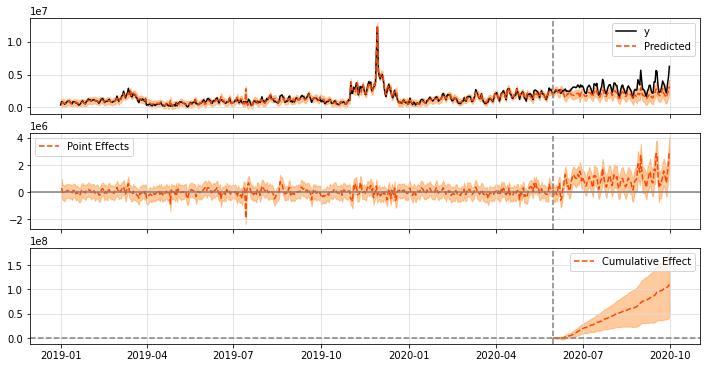

In [18]:
ci.plot(figsize=(12, 6))

In [24]:
print(ci.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 2921583.5. By contrast, in the absence of an
intervention, we would have expected an average response of 2019104.88.
The 95% interval of this counterfactual prediction is [1502667.14, 2567194.04].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 902478.62 with a 95% interval of
[354389.46, 1418916.36]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 356433184.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 246330800.0. The 95% interval of this prediction is [183325389.2, 313197669.6].


The above results are given in terms of abso

* O modelo é ajustado utilizando períodos antes da existencia do blog na marca, possibilitando a predição do cenário em que é incorporado o blog, para que então possamos entender o seu impacto na receita. 
* As linhas tracejadas verticais cinza indicam quando houve a intervenção do blog 
* O modelo foi bem ajustado, como mostra no sombreamento laranja, pois tanto a predição com o real está dentro deste.
* O 2º painel indica a diferença entre a métrica observada e a métrica predita do 1º painel
* O 3º paneil indica a soma dos valores do 2º painel, apresentando o efeito cumulativo no período observado.